<a href="https://colab.research.google.com/github/gabriellaawidd/Stage3_Assignment1_UNI174_RPP/blob/main/AI_AirPurifier_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import/Download/Install


In [1]:
!curl -L -o data.zip https://www.kaggle.com/api/v1/datasets/download/anubhav3242/carbon-monoxide-ppm-data-for-regression

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 52416  100 52416    0     0  84439      0 --:--:-- --:--:-- --:--:--  357k


In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn import metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
dataset_zip_path = "/content/data.zip"
extract_path = "/content/data"

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dataset_path = extract_path
asl_labels = sorted(os.listdir(dataset_path))
print("Success")

Success


#Data Exploration

In [4]:
data = pd.read_csv("data/arduino_data.csv")
data.head()

,timestamp,temp,humidity,ppm
0,2023-06-09T10:46:48+05:30,38,38,24.01
1,2023-06-09T10:47:49+05:30,38,36,22.39
2,2023-06-09T10:48:49+05:30,38,36,21.62
3,2023-06-09T10:49:50+05:30,38,36,21.62
4,2023-06-09T10:50:50+05:30,38,36,21.62


In [5]:
data.tail()

,timestamp,temp,humidity,ppm
10303,2023-06-17T02:51:13+05:30,28,32,25.71
10304,2023-06-17T02:52:13+05:30,28,32,25.71
10305,2023-06-17T02:53:14+05:30,28,32,25.71
10306,2023-06-17T02:54:14+05:30,28,32,28.43
10307,2023-06-17T02:55:15+05:30,28,32,30.36


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10308 entries, 0 to 10307
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  10308 non-null  object 
 1   temp       10308 non-null  int64  
 2   humidity   10308 non-null  int64  
 3   ppm        10308 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 322.3+ KB


In [7]:
data.describe()

,temp,humidity,ppm
count,10308.000000,10308.000000,10308.000000
mean,38.297051,32.617288,39.145906
std,4.053829,5.793688,18.363310
min,28.000000,21.000000,11.270000
25%,35.000000,29.000000,24.850000
50%,39.000000,32.000000,34.520000
75%,41.000000,36.000000,49.670000
max,45.000000,55.000000,328.600000


In [8]:
data.duplicated().sum()

np.int64(0)

In [9]:
data.isnull().sum()

,0
timestamp,0
temp,0
humidity,0
ppm,0


#Model Creation

In [10]:
data.head()

,timestamp,temp,humidity,ppm
0,2023-06-09T10:46:48+05:30,38,38,24.01
1,2023-06-09T10:47:49+05:30,38,36,22.39
2,2023-06-09T10:48:49+05:30,38,36,21.62
3,2023-06-09T10:49:50+05:30,38,36,21.62
4,2023-06-09T10:50:50+05:30,38,36,21.62


In [11]:
import numpy as np
# Normalize the data
scaler = MinMaxScaler()
numerical_features = ['ppm']
data_scaled = scaler.fit_transform(data[numerical_features])

# Split the data into training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 # Example sequence length
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the input data for LSTM
# The reshape is now correct as X_train has the expected number of features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Reshaped for 1 feature: ppm
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1) # Reshaped for 1 feature: ppm

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Changed input_shape to (10, 1)
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer with 1 unit (for ppm)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32) # Adjust epochs and batch size as needed

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get the original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Print or visualize the results (e.g., using matplotlib)
print("Predictions:", predictions[:5]) #Print first 5 prediction examples
print("Actual Values:", y_test[:5]) #Print first 5 actual values

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0012
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.5148e-04
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.9655e-04
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.1465e-04
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.7735e-04
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.1748e-04
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 4.4289e-04
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.3984e-04
Epoch 9/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.6431e-04
Epoch 10/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.4611e-04
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3143e-04
Test Loss: 0.00018677979824133217
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Predictions: [[30.238365]
 [31.731882]
 [30.727127]
 [31.50011 ]
 [32.63235 ]]
Actual Values: [[34.52]
 [28.43]
 [33.44]
 [34.52]
 [30.36]]


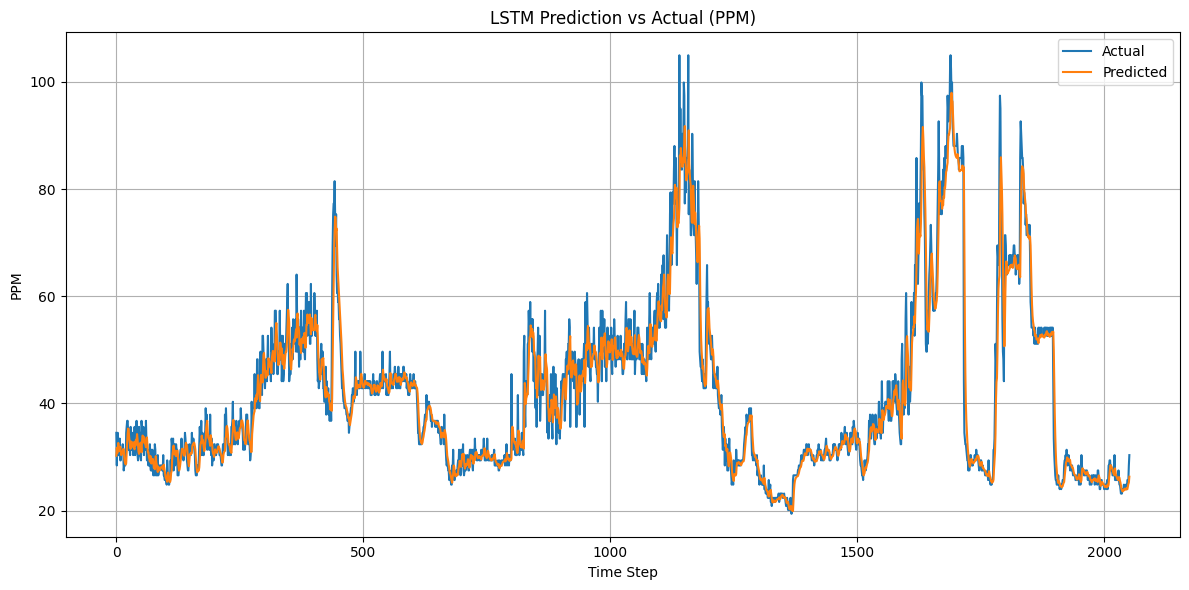

In [12]:
import matplotlib.pyplot as plt

# Plot hasil prediksi vs aktual
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Prediction vs Actual (PPM)')
plt.xlabel('Time Step')
plt.ylabel('PPM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:

import numpy as np
# Calculate evaluation metrics
mse = metrics.mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 18.80841764003764
Root Mean Squared Error (RMSE): 4.3368672610581065
Mean Absolute Error (MAE): 2.6380120017886393
R-squared (R2): 0.9284466730804047


In [14]:
# Save the model
model.save('lstm_model.keras')

import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [15]:
from tensorflow.keras.models import load_model
model = load_model("lstm_model.keras")